In [5]:
!pip install inference supervision opencv-python

^C


  Using cached inference-0.22.2-py3-none-any.whl.metadata (14 kB)
Using cached inference-0.22.2-py3-none-any.whl (725 kB)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


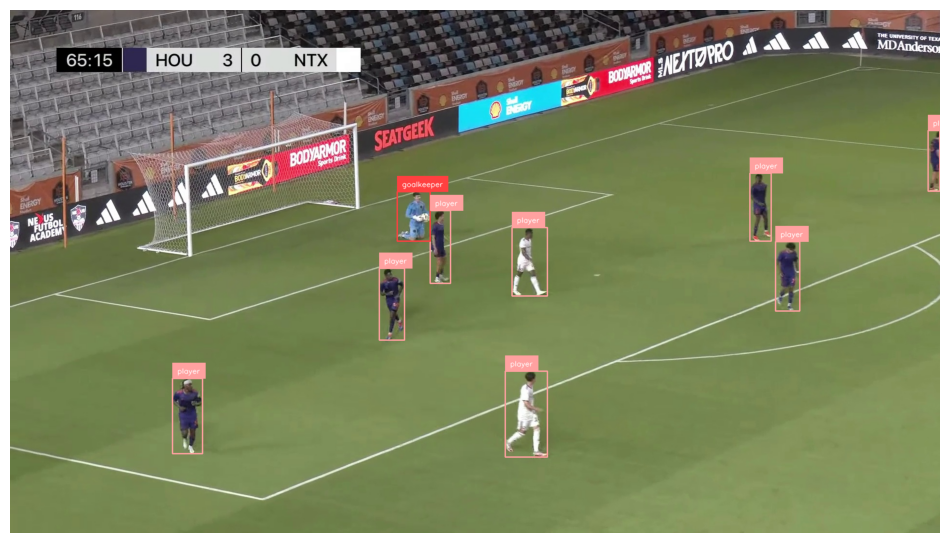

In [16]:
from inference import get_model
import supervision as sv
import cv2

# define the image url to use for inference
image_file = "images/frame800.jpg"
image = cv2.imread(image_file)

# load a pre-trained yolov8n model
objectModel = get_model(model_id="soccer-computer-vision-acffy/3")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
results = objectModel.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

In [17]:
import supervision as sv
import os

sourceVideoPath = "C:\\Users\\isss1\\OneDrive\\Documents\\Wondershare\\Wondershare Filmora\\Output\\clip_12.mp4"

boxAnnotator = sv.BoxAnnotator()
labelAnnotator = sv.LabelAnnotator()

def getAnnotatedFrame(frame, index):
    result = objectModel.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    labels = [f"{className} {confidence:.2f}" for className, confidence in zip(detections['class_name'], detections.confidence)]

    annotatedFrame = frame.copy()
    annotatedFrame = boxAnnotator.annotate(scene=annotatedFrame, detections=detections)
    annotatedFrame = labelAnnotator.annotate(scene=annotatedFrame, detections=detections, labels=labels)

    return annotatedFrame

outputFolder = "annotated-footage"

if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

print("Creating sample footage, please wait...")
sv.process_video(source_path=sourceVideoPath, target_path=f'{outputFolder}/annotated.mp4', callback=getAnnotatedFrame)
print(f"Finished creating sample footage. Check the {outputFolder} folder.")

Creating sample footage, please wait...
Finished creating sample footage. Check the annotated-footage folder.


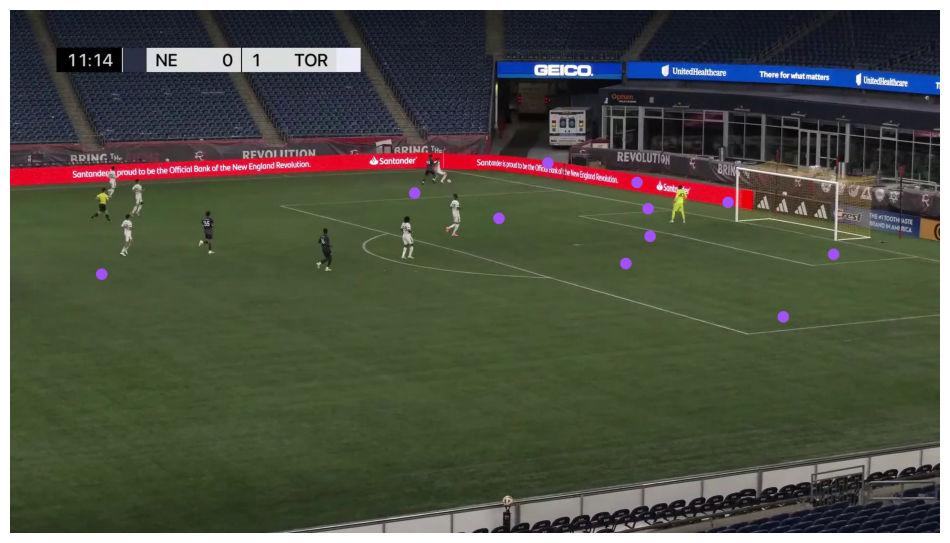

In [30]:
import supervision as sv
from inference import get_model
import numpy as np

# Keypoint Detection
# TODO: Using someone else's model so that I can implement some of the keypoint detection stuff, plan to use my own dataset

keypointModel = get_model(model_id="football-field-detection-f07vi/14")

print(keypointModel)

image_file = "images/frame355.jpg"
image = cv2.imread(image_file)

result = keypointModel.infer(image, confidence=0.3)[0]
keypoints = sv.KeyPoints.from_inference(result)

filter = keypoints.confidence > 0.5
keypoints.xy = keypoints.xy[filter][np.newaxis]

vertex_annotator = sv.VertexAnnotator(radius=12)
annotated_image = vertex_annotator.annotate(image.copy(), keypoints)

sv.plot_image(annotated_image)